In [1]:
!pip install 'pymc3 ==3.8'
!pip install 'arviz ==0.8.3'

     |████████████████████████████████| 911kB 3.4MB/s 
     |████████████████████████████████| 1.5MB 16.0MB/s 
     |████████████████████████████████| 4.3MB 31.7MB/s 
     |████████████████████████████████| 296kB 44.3MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
     |████████████████████████████████| 1.5MB 3.4MB/s 
  Found existing installation: arviz 0.9.0
    Uninstalling arviz-0.9.0:
      Successfully uninstalled arviz-0.9.0


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.interpolate import  griddata
import seaborn as sns
import arviz as az
import pymc3 as pm
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import  StandardScaler
import statsmodels.api as sm
sns.set()
np.random.seed(1)
plt.style.use('fivethirtyeight')

In [3]:
url = 'https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/WaffleDivorce.csv'
d = pd.read_csv(url,sep=';', header=0)
print(d.shape)
display(d.head(5))
age_scaler = StandardScaler()
marriage_scaler = StandardScaler()
### standardize the marriage rate
d['MedianAgeMarriage_s'] = age_scaler.fit_transform(d.MedianAgeMarriage.values.reshape(-1,1))
d['Marriage_s'] = marriage_scaler.fit_transform(d.Marriage.values.reshape(-1,1))
display(d.head(5))

(50, 13)


,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_s,Marriage_s
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.612445,0.022874
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.693671,1.565536
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.206314,0.049472
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.424706,1.671927
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.605947,-0.269700


### Code 5.1

In [4]:
with pm.Model() as m5_1:
  a = pm.Normal('a',10,10)
  bA = pm.Normal('bA',0,1)
  sigma_model = pm.Uniform('sigma_model',0,10)
  mu_model = pm.Deterministic('mu_model',a + bA*d.MedianAgeMarriage_s)
  Divorce = pm.Normal('Divorce',mu = mu_model, sigma = sigma_model, observed = d.Divorce)
  trace_m5_1 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, bA, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1300.48it/s]


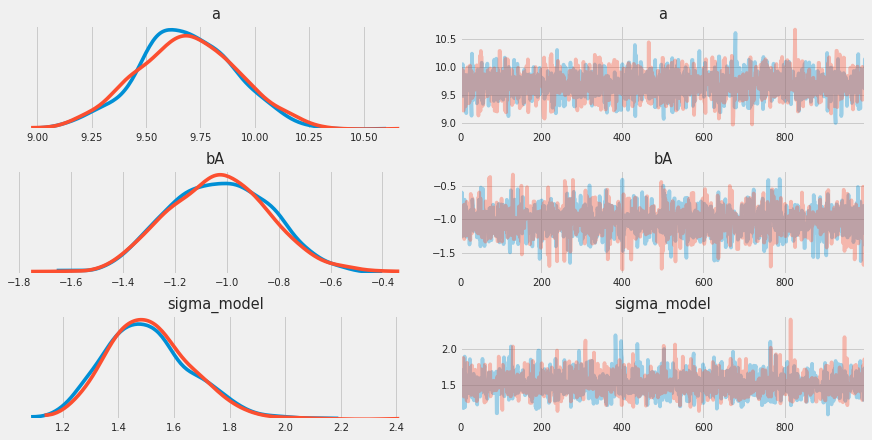

In [5]:
varnames = ['~mu_model']
az.plot_trace(trace_m5_1,varnames);

### Code 5.2

/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (50). Passed array should have shape (chains, draws, *shape)
  UserWarning,


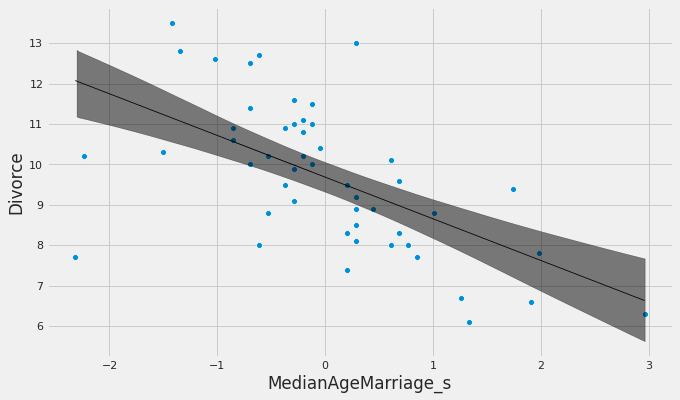

In [6]:
df_trace_m5_1 = pm.trace_to_dataframe(trace_m5_1)
df_trace_m5_1.filter(regex= 'mu_model*').mean(axis=0)
fig,axs = plt.subplots(1,1, figsize = (10,6))
sns.scatterplot(d.MedianAgeMarriage_s, d.Divorce , ax= axs)
sns.lineplot(d.MedianAgeMarriage_s,np.array(df_trace_m5_1.filter(regex= 'mu_model*')).mean(axis=0), ax= axs, color = 'black', linewidth = 0.8)
az.plot_hdi(d.MedianAgeMarriage_s, np.array(df_trace_m5_1.filter(regex= 'mu_model*')), color = 'black', hdi_prob= 0.89,ax= axs)
fig.show()

### Code 5.3

In [7]:
with pm.Model() as m5_2:
  a = pm.Normal('a',10,10)
  bR = pm.Normal('bR',0,1)
  sigma_model = pm.Uniform('sigma_model',0,10)
  mu_model = pm.Deterministic('mu_model',a + bR*d.Marriage_s)
  Divorce = pm.Normal('Divorce',mu = mu_model, sigma = sigma_model, observed = d.Divorce)
  trace_m5_2 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, bR, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1323.57it/s]


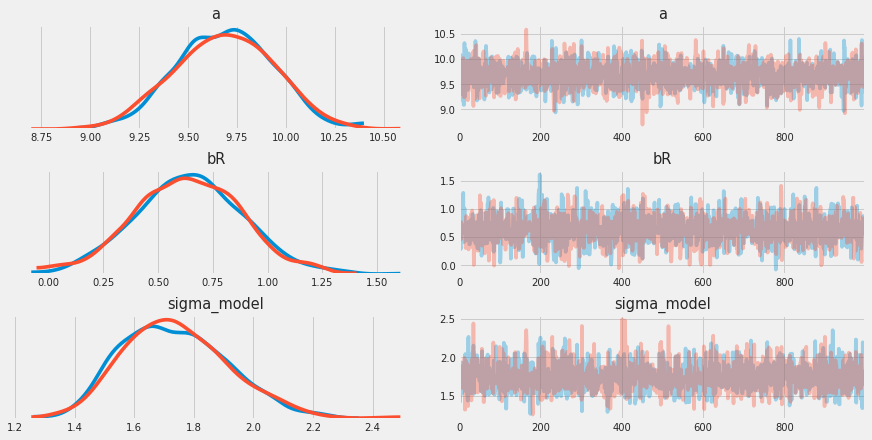

In [8]:
az.plot_trace(trace_m5_2, var_names= varnames);

### Code 5.2

/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (50). Passed array should have shape (chains, draws, *shape)
  UserWarning,


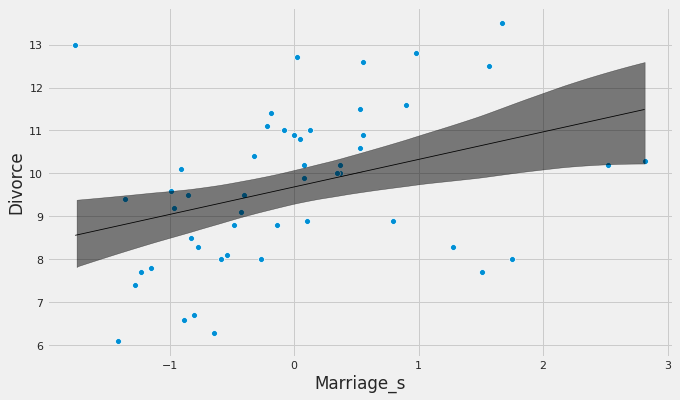

In [9]:
df_trace_m5_2 = pm.trace_to_dataframe(trace_m5_2)
df_trace_m5_2.filter(regex= 'mu_model*').mean(axis=0)
fig,axs = plt.subplots(1,1, figsize = (10,6))
sns.scatterplot(d.Marriage_s, d.Divorce , ax= axs)
sns.lineplot(d.Marriage_s,np.array(df_trace_m5_2.filter(regex= 'mu_model*')).mean(axis=0), ax= axs, color = 'black', linewidth = 0.8)
az.plot_hdi(d.Marriage_s, np.array(df_trace_m5_2.filter(regex= 'mu_model*')), color = 'black', hdi_prob= 0.89,ax= axs)
fig.show()

### Code 5.4

In [10]:
with pm.Model() as m5_3:
  a = pm.Normal('a',10,10)
  bA = pm.Normal('bA',0,1)
  bR = pm.Normal('bR',0,1)
  sigma_model = pm.Uniform('sigma_model',0,10)
  mu_model = pm.Deterministic('mu_model',a + bA*d.MedianAgeMarriage_s + bR*d.Marriage_s )
  Divorce = pm.Normal('Divorce',mu = mu_model, sigma = sigma_model, observed = d.Divorce)
  trace_m5_3 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, bR, bA, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 901.39it/s]


In [11]:
az.summary(trace_m5_3,varnames, hdi_prob= 0.89).iloc[:,0:4]

,mean,sd,hdi_5.5%,hdi_94.5%
a,9.683,0.211,9.354,10.012
bA,-1.124,0.281,-1.558,-0.672
bR,-0.135,0.288,-0.569,0.349
sigma_model,1.519,0.156,1.273,1.752


### Code 5.5

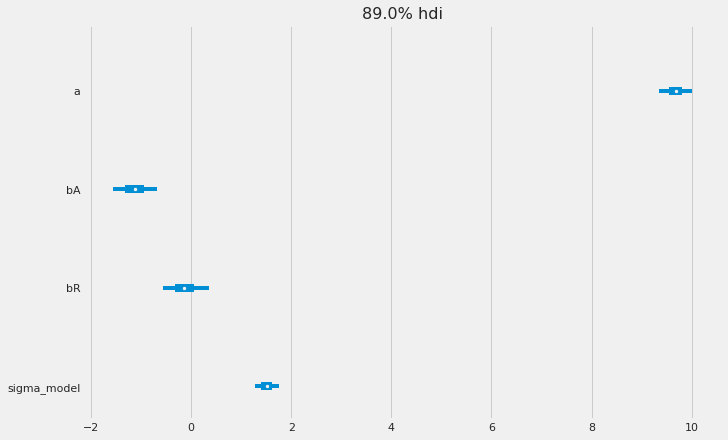

In [12]:
az.plot_forest(trace_m5_3,kind= 'forestplot',var_names=varnames,figsize=(10, 6),hdi_prob=0.89,combined=True);

### Code 5.6

In [13]:
with pm.Model() as m5_4:
  a = pm.Normal('a',mu=10,sigma=10)
  b = pm.Normal('b',0,1)
  sigma_model = pm.Uniform('sigma_model',lower=0,upper=10)
  mu_model = pm.Deterministic('mu_model',a + b*d.MedianAgeMarriage_s)
  Marriage_s = pm.Normal('Marriage_s',mu = mu_model, sigma = sigma_model, observed = d.Marriage_s)
  trace_m5_4 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, b, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1169.28it/s]


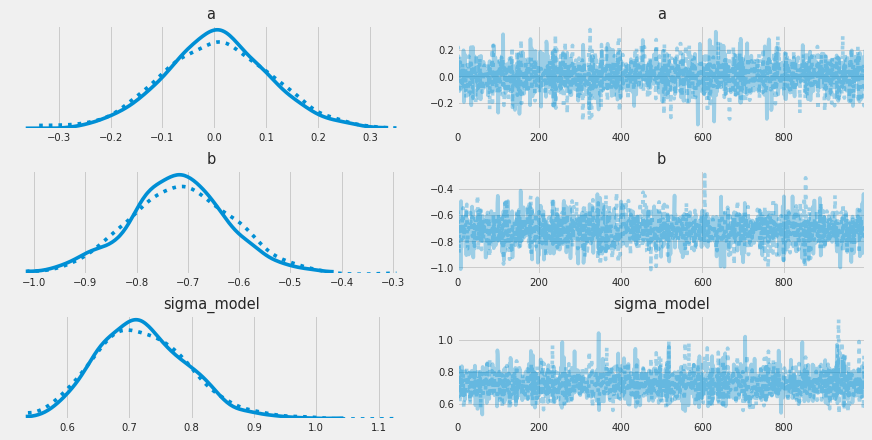

In [14]:
pm.traceplot(trace_m5_4, varnames);

In [15]:
az.summary(trace_m5_4,varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.004,0.106,-0.202,0.200,0.002,0.002,2189.0,959.0,2211.0,1208.0,1.0
b,-0.716,0.101,-0.911,-0.526,0.002,0.002,2228.0,2172.0,2232.0,1577.0,1.0
sigma_model,0.723,0.076,0.585,0.855,0.002,0.001,1752.0,1647.0,1882.0,896.0,1.0


### Code5.7

In [16]:
mu_pred = trace_m5_4['mu_model'].mean(axis=0)
m_resid = d.Marriage_s - mu_pred

### Code5.8

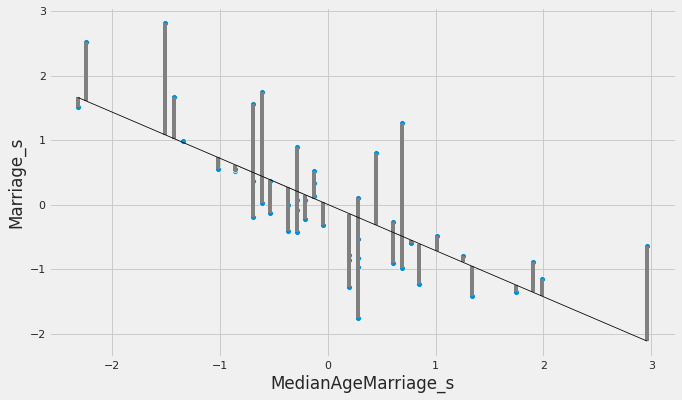

In [17]:
fig,axs = plt.subplots(1,1, figsize = (10,6))
sns.scatterplot(d.MedianAgeMarriage_s, d.Marriage_s, ax= axs)
sns.lineplot(d.MedianAgeMarriage_s,mu_pred, ax= axs, color = 'black', linewidth = 0.8)
axs.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + m_resid, colors='grey');
fig.show()

### Code for figure 5.4

In [18]:
with pm.Model() as res_m5_4:
  a = pm.Normal('a',0,10)
  sigma_model = pm.Uniform('sigma_model',0,10)
  b = pm.Normal('b',0,10)
  mu_model = pm.Deterministic('mu_model',a + b*m_resid)
  Divorce_pred = pm.Normal('Divorce_pred',mu = mu_model, sigma = sigma_model, observed = d.Divorce)
  trace_res_m5_4 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, sigma_model, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1268.98it/s]


In [19]:
az.summary(trace_res_m5_4,varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,9.680,0.273,9.164,10.167,0.006,0.004,2184.0,2182.0,2171.0,1358.0,1.0
b,-0.203,0.391,-0.952,0.503,0.009,0.008,1972.0,1218.0,1962.0,1372.0,1.0
sigma_model,1.889,0.203,1.540,2.261,0.004,0.003,2281.0,2101.0,2535.0,1399.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (50). Passed array should have shape (chains, draws, *shape)
  UserWarning,


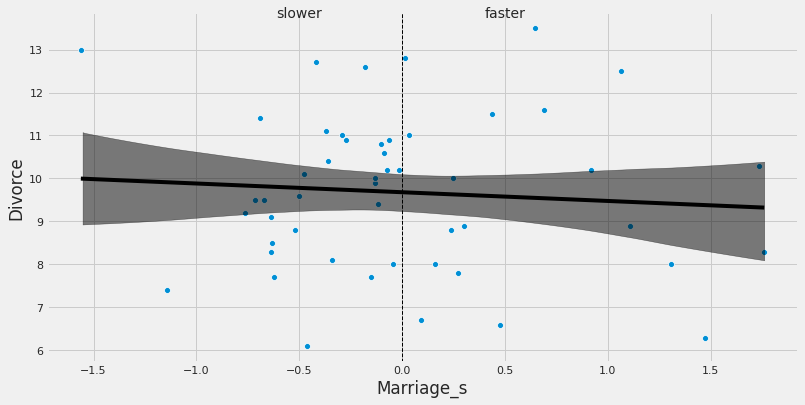

In [20]:
fig,axs = plt.subplots(1,1, figsize = (12,6))
sns.scatterplot(m_resid, d.Divorce, ax= axs)
axs.axvline(x=0.0,color = 'black',linestyle ='--',linewidth =1)
axs.text(-0.5, 14, 'slower',horizontalalignment='center',verticalalignment='top',multialignment='center')
axs.text( 0.5, 14, 'faster',horizontalalignment='center',verticalalignment='top',multialignment='center')
sns.lineplot(m_resid,trace_res_m5_4['mu_model'].mean(axis=0), ax= axs, color = 'black')
az.plot_hdi(m_resid, trace_res_m5_4['mu_model'], color = 'black', hdi_prob= 0.89,ax= axs)
fig.show()

### Code 5.9

/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (30). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (30). Passed array should have shape (chains, draws, *shape)
  UserWarning,


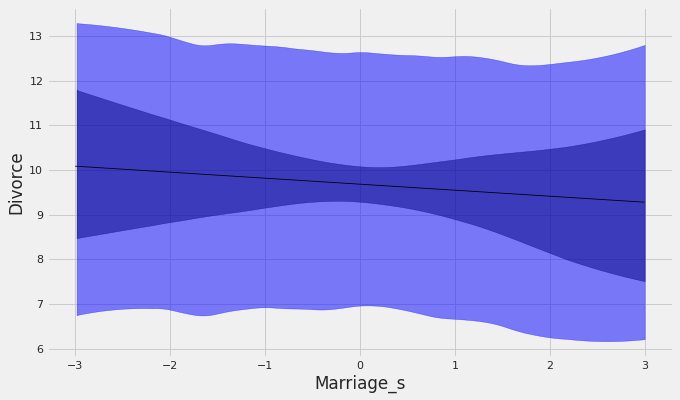

In [21]:
num_of_points = 30
A_avg = np.mean(d.MedianAgeMarriage_s)
R_seq = np.linspace(start= -3, stop =3, num= num_of_points)
mu_pred = trace_m5_3['a'] + trace_m5_3['bR']*R_seq.reshape(num_of_points,1) 
div_pred = np.random.normal(mu_pred, trace_m5_3['sigma_model'])
fig,axs = plt.subplots(1,1, figsize = (10,6))
sns.lineplot(R_seq, np.mean(mu_pred, axis = 1) , color = 'black', linewidth = 0.8)
az.plot_hdi(R_seq, mu_pred.T, ax= axs,color = 'black')
az.plot_hdi(R_seq, div_pred.T, ax= axs,color = 'blue')
axs.set_xlabel('Marriage_s')
axs.set_ylabel('Divorce')
fig.show()

### Code 5.10

/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (30). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (30). Passed array should have shape (chains, draws, *shape)
  UserWarning,


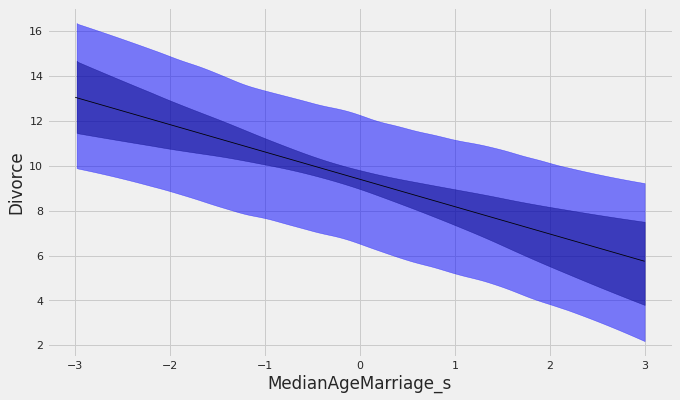

In [22]:
num_of_points = 30
R_avg = np.mean(d.Marriage_s)
A_seq = np.linspace(start= -3, stop =3.5, num= num_of_points)
mu_pred = trace_m5_3['a'] + trace_m5_3['bA']*A_seq.reshape(num_of_points,1) 
div_pred = np.random.normal(mu_pred, trace_m5_3['sigma_model'])
fig,axs = plt.subplots(1,1, figsize = (10,6))
sns.lineplot(R_seq, np.mean(mu_pred, axis = 1) , color = 'black', linewidth = 0.8)
az.plot_hdi(R_seq, mu_pred.T, ax= axs,color = 'black')
az.plot_hdi(R_seq, div_pred.T, ax= axs,color = 'blue')
axs.set_xlabel('MedianAgeMarriage_s')
axs.set_ylabel('Divorce')
fig.show()

### Code 5.11

In [23]:
mu_pred = trace_m5_3['mu_model']
Divorce_pred = pm.sample_posterior_predictive(trace_m5_3, 1000, m5_3)
Divorce_mean = np.mean(Divorce_pred['Divorce'], axis=0)
Divorce_hdi = az.hdi(Divorce_pred['Divorce'])

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:02<00:00, 446.28it/s]
/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (1000) than draws (50). Passed array should have shape (chains, draws, *shape)
  UserWarning,


In [24]:
Divorce_pred['Divorce']

array([[ 9.45900893, 11.07056767,  9.67952585, ..., 11.9155392 ,
         9.7944412 , 11.61258602],
       [10.76492632, 10.61896705,  8.55209066, ...,  8.73524677,
        12.16309054, 11.75740045],
       [ 9.42791858, 10.33066089, 10.2792967 , ..., 10.79464132,
         7.06148022, 12.73080349],
       ...,
       [10.09257827, 11.2954362 , 11.55488286, ..., 12.40119631,
         7.53267705, 10.81047906],
       [13.75476748,  9.50793278,  8.96888667, ..., 10.48848449,
         9.16472419,  9.93689334],
       [11.67799171, 11.20656974,  8.22195129, ...,  8.82249835,
        10.58559407,  9.61828413]])

### Code 5.12

/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (50). Passed array should have shape (chains, draws, *shape)
  UserWarning,


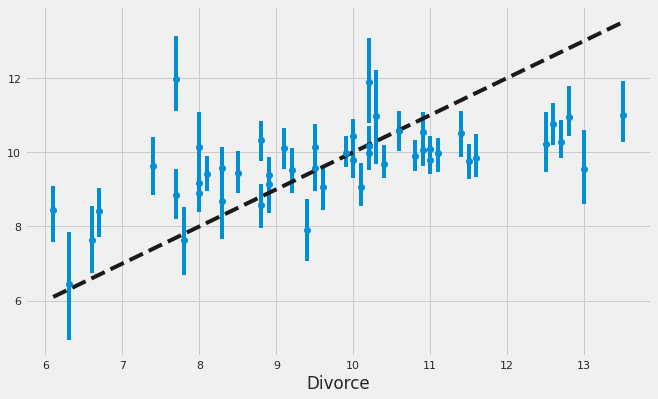

In [25]:
mu_hpd = az.hdi(mu_pred, hdi_prob=0.95)
fig,axs = plt.subplots(1,1, figsize = (10,6))
sns.scatterplot(d.Divorce,Divorce_mean,ax= axs)
axs.errorbar(d.Divorce,Divorce_mean,yerr= np.abs(Divorce_mean - mu_hpd.T),fmt='C0o')
min_x, max_x = d.Divorce.min(), d.Divorce.max()
axs.plot([min_x, max_x], [min_x, max_x], 'k--')
fig.show()

### Code 5.14

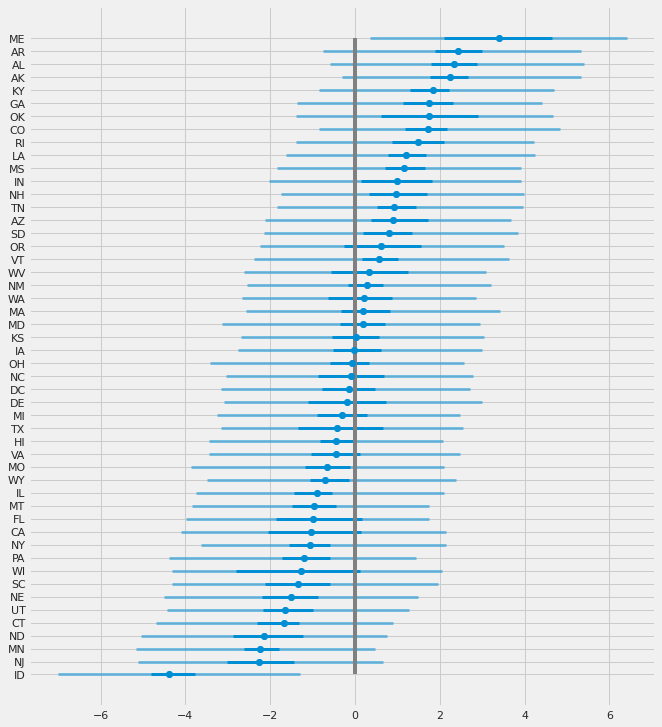

In [26]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(Divorce_pred['Divorce'].mean(0)-mu_hpd.T),
             fmt='C0o',lw=3)

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(Divorce_pred['Divorce'].mean(0)-Divorce_hdi.T),
             fmt='C0o', lw=3, alpha=0.5)

plt.yticks(y_points, y_label);
plt.vlines(0, 0, 1, 'grey')
plt.show()

### Code 5.15

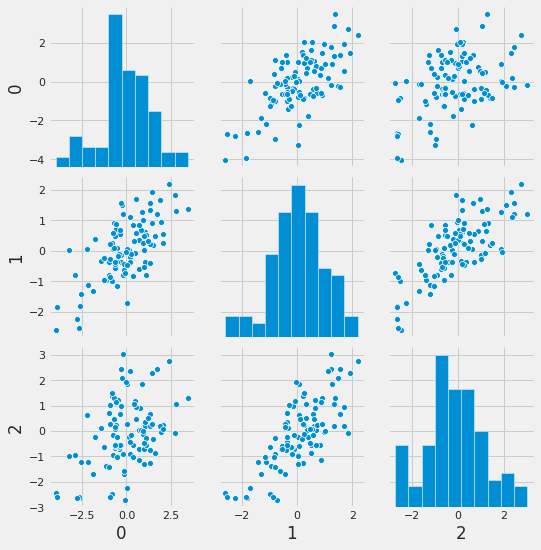

In [27]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T
sns.pairplot(d)

### Code 5.16

In [28]:
url = 'https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/milk.csv'
d = pd.read_csv(url,sep=';', header=0)
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


### Code 5.17

In [29]:
try:
  with pm.Model() as m5_5:
    a = pm.Normal('a',0,100)
    bn = pm.Normal('b',0,1)
    sigma_model = pm.Uniform('sigma_model',0,1)
    mu_model = pm.Deterministic('mu_model',a + bn*d['neocortex.perc'])
    kcal_per_g = pm.Normal('kcal_per_g', mu=mu_model, sd=sigma_model, observed = d['kcal.per.g'])
    trace_m5_5 = pm.sample(1000, tune = 1000)
except Exception as e:
  print('\n Caught Exception')
  print(e)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, b, a]
Sampling chain 0, 0 divergences:   0%|          | 0/2000 [00:01<?, ?it/s]


 Caught Exception
Bad initial energy


### Code 5.18

In [30]:
d[d['neocortex.perc'].isna()]

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN
13,New World Monkey,Leontopithecus rosalia,0.71,36.90,21.27,41.83,0.60,NaN
14,Old World Monkey,Chlorocebus pygerythrus,0.73,39.17,14.65,46.18,3.47,NaN
16,Old World Monkey,M fuscata,0.72,53.05,13.00,33.95,7.08,NaN
18,Old World Monkey,M sinica,0.79,48.90,13.91,37.19,7.94,NaN
20,Ape,Nomascus concolor,0.48,15.96,12.52,71.52,7.59,NaN


### Code 5.19

In [31]:
dcc = d[~d['neocortex.perc'].isna()].copy()
dcc.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85


### Code 5.20

In [32]:
with pm.Model() as m5_5:
  a = pm.Normal('a',0,100)
  bn = pm.Normal('bn',0,1)
  sigma_model = pm.Uniform('sigma_model',0,1)
  mu_model = pm.Deterministic('mu_model',a + bn*dcc['neocortex.perc'])
  kcal_per_g = pm.Normal('kcal_per_g', mu=mu_model, sd=sigma_model, observed = dcc['kcal.per.g'])
  trace_m5_5 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, bn, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:09<00:00, 203.55it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


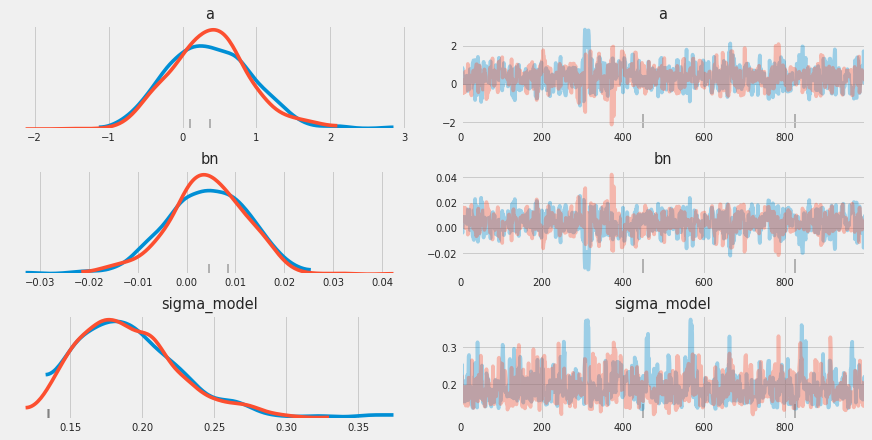

In [33]:
az.plot_trace(trace_m5_5, varnames);

### Code 5.21

In [34]:
varnames = ['~mu_model']
df=az.summary(trace_m5_5,hdi_prob=0.89,var_names = varnames).round(3)
df.iloc[:,0:4]

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.378,0.566,-0.510,1.226
bn,0.004,0.008,-0.009,0.017
sigma_model,0.194,0.039,0.134,0.244


### Code 5.22

In [35]:
trace_m5_5['bn'].mean()*(76 - 55)

0.08672511613940134

### Code 5.23

/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (50). Passed array should have shape (chains, draws, *shape)
  UserWarning,


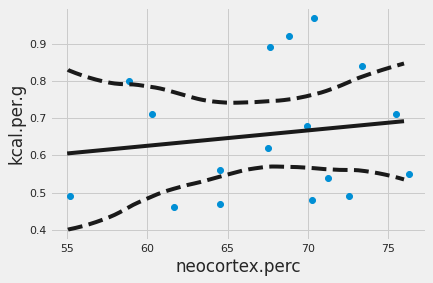

In [36]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_m5_5['a'] + trace_m5_5['bn'] * seq[:,None]
plt.plot(d['neocortex.perc'], d['kcal.per.g'], 'C0o')
plt.plot(seq, mu_pred.mean(1), 'k')
az.plot_hpd(seq, mu_pred.T,
            fill_kwargs={'alpha': 0},
            plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'})
plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

### Code 5.24

In [37]:
dcc['log_mass'] = np.log(dcc['mass'])

### Code 5.25

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, bn, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1063.83it/s]


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.705,0.059,0.614,0.791
bn,-0.032,0.024,-0.069,0.005
sigma_model,0.182,0.037,0.125,0.234


/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (50). Passed array should have shape (chains, draws, *shape)
  UserWarning,


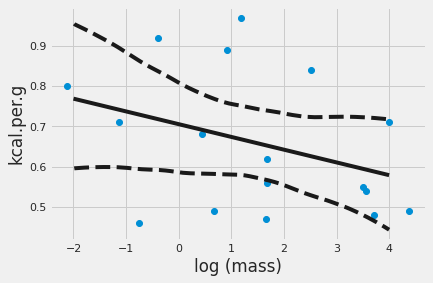

In [38]:
with pm.Model() as m5_6:
  a = pm.Normal('a',0,100)
  bn = pm.Normal('bn',0,1)
  sigma_model = pm.Uniform('sigma_model',0,1)
  mu_model = pm.Deterministic('mu_model',a + bn*dcc['log_mass'])
  kcal_per_g = pm.Normal('kcal_per_g', mu=mu_model, sd=sigma_model, observed = dcc['kcal.per.g'])
  trace_m5_6 = pm.sample(1000, tune = 1000)
varnames = ['~mu_model']
df=az.summary(trace_m5_6,hdi_prob=0.89,var_names = varnames).round(3)
display(df.iloc[:,0:4])


seq = np.linspace(-2, 4, 50)
mu_pred = trace_m5_6['a'] + trace_m5_6['bn'] * seq[:,None]

plt.plot(dcc['log_mass'], dcc['kcal.per.g'], 'C0o')

plt.plot(seq, mu_pred.mean(1), 'k')
az.plot_hpd(seq, mu_pred.T,
            fill_kwargs={'alpha': 0},
            plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'})
plt.xlabel('log (mass)')
plt.ylabel('kcal.per.g');

### Code 5.26

In [39]:
with pm.Model() as m5_7:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1, shape=2)
    sigma_model = pm.Uniform('sigma', lower=0, upper=1)
    mu_model = pm.Deterministic('mu_model', a + bn[0] * dcc['neocortex.perc'] + bn[1] * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu_model, sd=sigma_model, observed=dcc['kcal.per.g'])
    trace_m5_7 = pm.sample(1000, tune=1000)
df=az.summary(trace_m5_7,hdi_prob=0.89,var_names = varnames).round(3)
df.iloc[:,0:4]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bn, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:16<00:00, 124.68it/s]
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.35471441033177065, but should be close to 0.8. Try to increase the number of tuning steps.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5924842535844589, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.876,0.644,-1.739,0.147
bn[0],0.025,0.010,0.009,0.038
bn[1],-0.088,0.030,-0.129,-0.041
sigma,0.137,0.029,0.100,0.178


### Code 5.27

/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (50). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (50). Passed array should have shape (chains, draws, *shape)
  UserWarning,


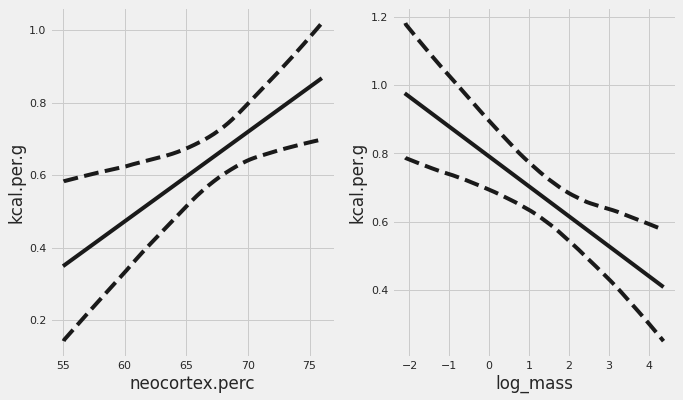

In [40]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_m5_7['a'] + trace_m5_7['bn'][:,0] * seq[:,None] + trace_m5_7['bn'][:,1] * dcc['log_mass'].mean()
fig,axs = plt.subplots(1,2, figsize = (10,6))
axs[0].plot(seq, mu_pred.mean(1), 'k')
az.plot_hpd(seq, mu_pred.T,
            fill_kwargs={'alpha': 0},
            plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'}, ax = axs[0])

axs[0].set_xlabel('neocortex.perc')
axs[0].set_ylabel('kcal.per.g')

seq = np.linspace(dcc['log_mass'].min(), dcc['log_mass'].max(), 50)
mu_pred = trace_m5_7['a'] + trace_m5_7['bn'][:,0] * dcc['neocortex.perc'].mean() + trace_m5_7['bn'][:,1] * seq[:,None] 
axs[1].plot(seq, mu_pred.mean(1), 'k')

az.plot_hpd(seq, mu_pred.T,
            fill_kwargs={'alpha': 0},
            plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'}, ax = axs[1])

axs[1].set_xlabel('log_mass')
axs[1].set_ylabel('kcal.per.g')
fig.show()

### Code 5.28

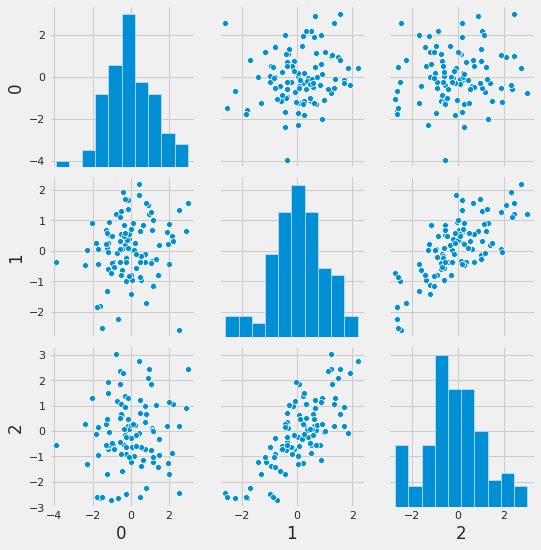

In [41]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(rho*x_pos, (1-rho**2)**0.5)
y = stats.norm.rvs(x_pos - x_neg)
d = pd.DataFrame([y, x_real, x_spur]).T
sns.pairplot(d)

### Code 5.29

In [42]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.5) 
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)

In [43]:
leg_prop

array([0.47333734, 0.64282927, 0.70623604, 0.7666434 , 0.8200199 ,
       0.73416351, 0.76348469, 0.83530864, 0.51807053, 0.65081155,
       0.61160462, 0.58288296, 0.65910994, 0.713144  , 0.68788973,
       0.48112141, 0.77340591, 0.57350727, 0.50488127, 0.4400435 ,
       0.49119274, 0.60956658, 0.79724257, 0.68774017, 0.58192814,
       0.74324954, 0.77033091, 0.47417877, 0.60498628, 0.48026823,
       0.43367208, 0.84140638, 0.4905643 , 0.42896136, 0.68935973,
       0.45733299, 0.63777576, 0.52406212, 0.79199008, 0.54811236,
       0.81751275, 0.71167887, 0.63831745, 0.43752887, 0.70685909,
       0.66073738, 0.42276923, 0.6296728 , 0.52487046, 0.67496959,
       0.58888533, 0.77928587, 0.85342676, 0.85234323, 0.80846782,
       0.60293913, 0.52923351, 0.5474869 , 0.72164766, 0.48530194,
       0.75760824, 0.73195092, 0.71564427, 0.58829038, 0.64600162,
       0.68226527, 0.85957858, 0.78249412, 0.68320652, 0.83758214,
       0.4288798 , 0.62837974, 0.62612059, 0.62719774, 0.63657

### Code 5.30

In [44]:
with pm.Model() as m5_8:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    mu_model = pm.Deterministic('mu_model', a + bl * leg_left + br * leg_right)    
    sigma_model = pm.Uniform('sigma_model', lower=0 , upper=10)
    height_p = pm.Normal('height_p', mu=mu_model, sd=sigma_model, observed=height)
    trace_m5_8 = pm.sample(1000, tune=1000)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, br, bl, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [02:17<00:00, 14.59it/s]


In [45]:
varnames = ['~mu_model']
df=az.summary(trace_m5_8,hdi_prob=0.89,var_names = varnames).round(3)
df.iloc[:,0:4]

,mean,sd,hdi_5.5%,hdi_94.5%
a,4.703,0.512,3.830,5.465
bl,0.262,3.992,-6.052,6.717
br,0.541,3.976,-5.954,6.814
sigma_model,1.451,0.104,1.286,1.616


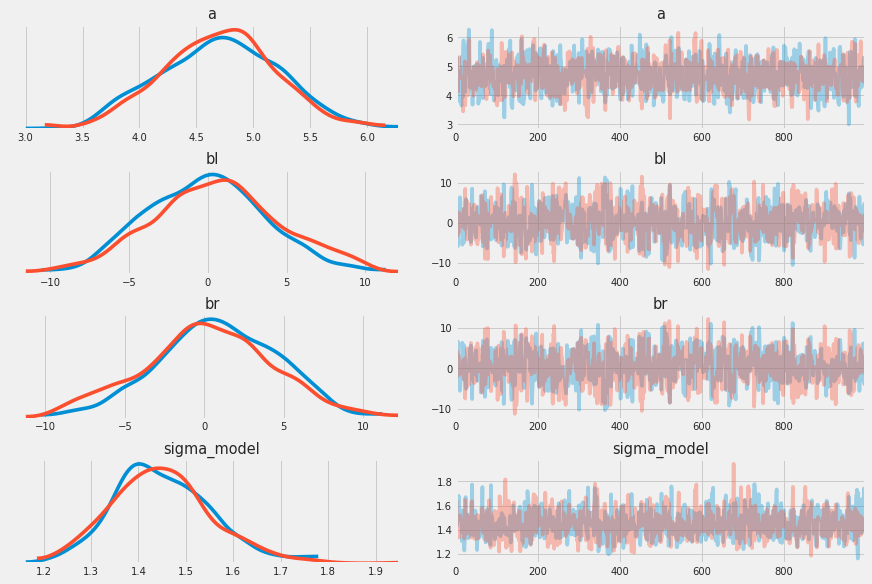

In [46]:
az.plot_trace(trace_m5_8, varnames);

### Code 5.31

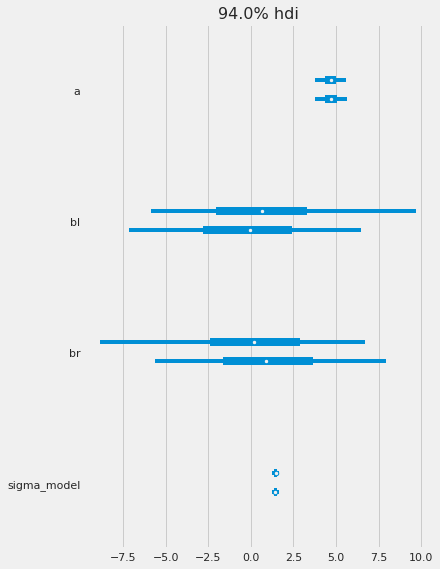

In [47]:
az.plot_forest(trace_m5_8, var_names=varnames);

### Code 5.32

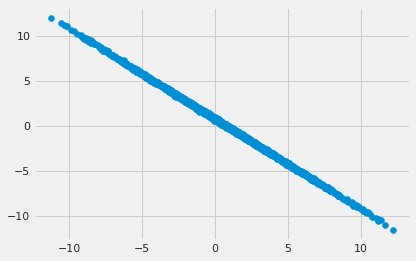

In [48]:
plt.scatter(trace_m5_8['br'], trace_m5_8['bl']);

### Code 5.33

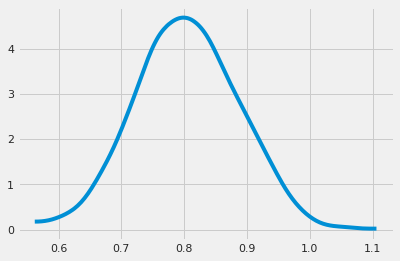

In [49]:
sum_blbr = trace_m5_8['br'] + trace_m5_8['bl']
az.plot_kde(sum_blbr);

### Code 5.34

In [50]:
with pm.Model() as m5_9:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    mu_model = pm.Deterministic('mu_model', a + bl * leg_left)    
    sigma_model = pm.Uniform('sigma_model', lower= 0 , upper= 10)
    height_p = pm.Normal('height',mu=mu_model, sd=sigma_model, observed=height)
    trace_m5_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, bl, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 548.19it/s]


In [51]:
varnames = ['~mu_model']
df=az.summary(trace_m5_9,hdi_prob=0.89,var_names = varnames).round(3)
df.iloc[:,0:4]

,mean,sd,hdi_5.5%,hdi_94.5%
a,4.663,0.504,3.892,5.453
bl,0.811,0.080,0.682,0.934
sigma_model,1.440,0.107,1.262,1.594


### Code 5.35

In [52]:
url = 'https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/milk.csv'
milk = pd.read_csv(url,sep=';', header=0)
print(milk.shape)
display(milk.head(5))

(29, 8)


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### Code 5.36

In [53]:
with pm.Model() as m5_10:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    mu_model = pm.Deterministic('mu_model',a + bf * milk['perc.fat'])    
    sigma_model = pm.Uniform('sigma_model', lower= 0 , upper= 10)
    kcalperg_p = pm.Normal('kcal.per.g',mu=mu_model, sd=sigma_model, observed=milk['kcal.per.g'])
    trace_m5_10 = pm.sample(1000, tune=1000)

with pm.Model() as m5_11:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu_model = pm.Deterministic('mu_model',a + bl * milk['perc.lactose'])    
    sigma_model = pm.Uniform('sigma_model', lower= 0 , upper= 10)
    kcalperg_p = pm.Normal('kcal.per.g',mu=mu_model, sd=sigma_model, observed=milk['kcal.per.g'])
    trace_m5_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, bf, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 657.62it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, bl, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:03<00:00, 513.50it/s]


In [54]:
varnames = ['~mu_model']
df=az.summary(trace_m5_10,hdi_prob=0.89,var_names = varnames).round(3)
display(df.iloc[:,0:4])
varnames = ['~mu_model']
df=az.summary(trace_m5_11,hdi_prob=0.89,var_names = varnames).round(3)
display(df.iloc[:,0:4])

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.30,0.041,0.234,0.360
bf,0.01,0.001,0.008,0.012
sigma_model,0.08,0.011,0.063,0.098


,mean,sd,hdi_5.5%,hdi_94.5%
a,1.167,0.046,1.101,1.244
bl,-0.011,0.001,-0.012,-0.009
sigma_model,0.067,0.010,0.052,0.082


### Code 5.37

In [55]:
with pm.Model() as m5_12:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu_model = pm.Deterministic('mu_model',a + bf * milk['perc.fat'] + bl * milk['perc.lactose'])    
    sigma_model = pm.Uniform('sigma_model', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu_model, sd=sigma_model, observed=milk['kcal.per.g'])
    trace_m5_12 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, bl, bf, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:13<00:00, 149.17it/s]


In [56]:
varnames = ['~mu_model']
df=az.summary(trace_m5_12,hdi_prob=0.89,var_names = varnames).round(3)
display(df.iloc[:,0:4])

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.999,0.217,0.661,1.352
bf,0.002,0.003,-0.002,0.006
bl,-0.009,0.003,-0.013,-0.005
sigma_model,0.068,0.009,0.053,0.081


### Code 5.38

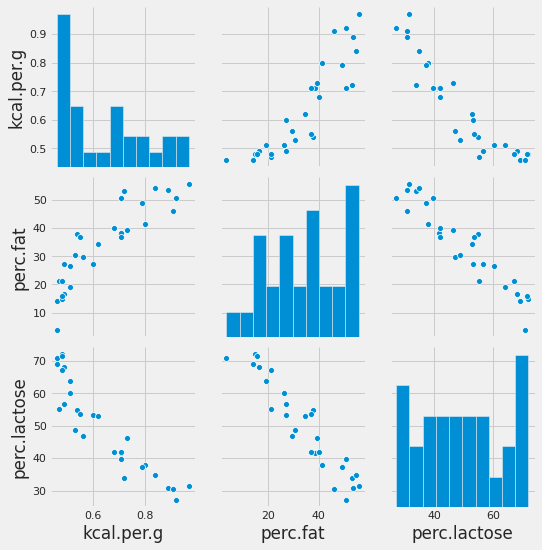

In [57]:
df = milk[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

### Code 5.39

In [58]:
milk.corr()['perc.fat']['perc.lactose']

-0.9416373456839282

### Code 5.40

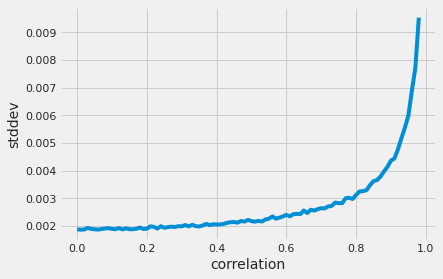

In [82]:
def simcoll(r = 0.9):
    milk['x'] = stats.norm.rvs(size=len(milk), loc = r * milk['perc.fat'],
                       scale = np.sqrt((1 - r**2) * milk['perc.fat'].var()))
    X = np.column_stack((milk['perc.fat'], milk['x']))
    m = sm.OLS(milk['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);


### Code 5.41

In [103]:
## Number of plants
N = 100
## Simulate intial heights
h0 = np.random.normal(loc= 10, scale= 2, size= N)
treatment = np.concatenate((np.zeros(N//2),np.ones(N//2)))
fungus = np.random.binomial(n= 1, p=(0.5-treatment * 0.4), size=N)
h1 = h0 + np.random.normal(5 - 3*fungus, size= N)
# compose a clean data frame
d = pd.DataFrame({'h0': h0,'h1': h1, 'Treatment':treatment,'Fungus': fungus})

### Code 5.42

In [108]:
with pm.Model() as m5_13:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    bf = pm.Normal('bf',mu = 0, sd=10)
    mu_model = pm.Deterministic('mu_model',a + bh * h0 + bt * treatment + bf * fungus)
    sigma_model = pm.Uniform('sigma_model', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu_model, sd=sigma_model, observed = d['h1'])
    trace_m5_13 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, bf, bt, bh, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:06<00:00, 321.46it/s]


In [110]:
az.summary(trace_m5_13, varnames, hdi_prob=.89).round(3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,5.968,0.604,5.036,6.949,0.022,0.015,787.0,780.0,789.0,785.0,1.0
bh,0.908,0.056,0.828,1.010,0.002,0.001,749.0,749.0,752.0,903.0,1.0
bt,0.010,0.266,-0.463,0.391,0.008,0.006,1213.0,952.0,1227.0,1267.0,1.0
bf,-3.138,0.286,-3.596,-2.687,0.008,0.005,1409.0,1400.0,1412.0,1387.0,1.0
sigma_model,1.141,0.082,1.005,1.262,0.002,0.001,1707.0,1705.0,1697.0,1263.0,1.0


### Code 5.43

In [113]:
with pm.Model() as m5_14:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    mu_model = pm.Deterministic('mu_model',a + bh * h0 + bt * treatment)
    sigma_model = pm.Uniform('sigma_model', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu_model, sd=sigma_model, observed = d['h1'])
    trace_m5_14 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, bt, bh, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:06<00:00, 329.03it/s]


In [114]:
az.summary(trace_m5_14, varnames, hdi_prob=.89).round(3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,3.785,0.857,2.455,5.234,0.028,0.020,925.0,925.0,911.0,1006.0,1.0
bh,0.965,0.085,0.839,1.114,0.003,0.002,939.0,937.0,939.0,1120.0,1.0
bt,1.335,0.362,0.770,1.894,0.010,0.007,1189.0,1186.0,1203.0,1043.0,1.0
sigma_model,1.717,0.127,1.528,1.924,0.004,0.003,1074.0,1066.0,1094.0,1052.0,1.0


### Code 5.44

In [116]:
url = 'https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/Howell1.csv'
d = pd.read_csv(url,sep=';', header=0)
print(d.shape)
display(d.info())
d.head()

(544, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


None

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [117]:
with pm.Model() as m5_15:
    a = pm.Normal('a',mu = 178, sd=100)
    bm = pm.Normal('bm',mu = 0, sd=10)
    mu_model = pm.Deterministic('mu_model',a + bm * d.male)
    sigma_model = pm.Uniform('sigma_model', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu_model, sd=sigma_model, observed = d.height)
    trace_m5_15 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, bm, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 857.34it/s]


In [119]:
az.summary(trace_m5_15, varnames, hdi_prob=.89).round(3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,134.852,1.569,132.330,137.266,0.044,0.031,1301.0,1301.0,1304.0,1344.0,1.0
bm,7.258,2.258,3.728,10.897,0.063,0.044,1302.0,1292.0,1312.0,1383.0,1.0
sigma_model,27.431,0.833,25.971,28.663,0.024,0.017,1249.0,1242.0,1259.0,1260.0,1.0


### Code 5.46

In [127]:
mu.model = trace_m5_15['a'] + trace_m5_15['bm']  
az.hdi(mu.model)

array([138.97578679, 145.26238795])

### Code 5.47

In [129]:
with pm.Model() as m5_15b:
    af = pm.Normal('af',mu = 178, sd=100)
    am = pm.Normal('am',mu = 178, sd=100)
    mu_model = pm.Deterministic('mu_model',af*(1 - d.male) + am*d.male)
    sigma_model = pm.Uniform('sigma_model', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu_model, sd=sigma_model, observed = d.height)
    trace_m5_15b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, am, af]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1210.35it/s]


In [130]:
az.summary(trace_m5_15b, varnames, hdi_prob=.89).round(3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
af,134.618,1.609,132.080,137.070,0.028,0.020,3346.0,3344.0,3451.0,1567.0,1.0
am,142.318,1.703,139.589,144.955,0.034,0.024,2481.0,2476.0,2475.0,1652.0,1.0
sigma_model,27.409,0.862,26.047,28.771,0.017,0.012,2654.0,2620.0,2706.0,1436.0,1.0


### Code 5.48

In [141]:
url = 'https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/milk.csv'
d = pd.read_csv(url,sep=';', header=0)
print(d.shape)
display(d.info())
display(d.head(n=2))
print(d.clade.unique())

(29, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


None

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN


['Strepsirrhine' 'New World Monkey' 'Old World Monkey' 'Ape']


### Code 5.49

In [ ]:
d['clade.NWM'] = d['clade'].apply(lambda x: 1 if x == 'New World Monkey' else 0)

### Code 5.50

In [143]:
d['clade.OWM'] = d['clade'].apply(lambda x: 1 if x == 'Old World Monkey' else 0)
d['clade.S'] = d['clade'].apply(lambda x: 1 if x == 'Strepsirrhine' else 0)

In [144]:
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,clade.NWM,clade.OWM,clade.S
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,0,0,1
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,0,0,1
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,0,0,1
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,0,0,1
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,0,0,1


### Code 5.51

In [145]:
with pm.Model() as m5_16:
    b_NWM = pm.Normal('b_NWM',mu = 0, sd=1)
    b_OWM = pm.Normal('b_OWM',mu = 0, sd=1)
    b_S = pm.Normal('b_S',mu = 0, sd=1)
    a = pm.Normal('a',mu = 0.6, sd=10)
    mu_model = pm.Deterministic('mu_model',a + b_NWM * d['clade.NWM'] + b_OWM * d['clade.OWM'] + b_S * d['clade.S'])
    sigma_model = pm.Uniform('sigma_model', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = mu_model, sd=sigma_model, observed = d['kcal.per.g'])
    trace_m5_16 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma_model, a, b_S, b_OWM, b_NWM]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 691.17it/s]


In [146]:
az.summary(trace_m5_16, varnames, hdi_prob=.89).round(3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b_NWM,0.169,0.060,0.071,0.261,0.002,0.001,902.0,893.0,895.0,1145.0,1.01
b_OWM,0.243,0.068,0.140,0.356,0.002,0.002,1006.0,972.0,999.0,1334.0,1.00
b_S,-0.038,0.073,-0.154,0.073,0.002,0.001,1198.0,1198.0,1201.0,1225.0,1.00
a,0.546,0.044,0.476,0.613,0.002,0.001,791.0,791.0,793.0,1083.0,1.01
sigma_model,0.129,0.019,0.098,0.156,0.001,0.000,971.0,966.0,971.0,941.0,1.00


In [157]:
mu_ape = trace_m5_16['a']
display('mu_ape ',az.summary(mu_ape, hdi_prob= 0.89))

mu_NWM = trace_m5_16['a'] + trace_m5_16['b_NWM']
display('mu_NWM ',az.summary(mu_NWM, hdi_prob= 0.89))

mu_OWM = trace_m5_16['a'] + trace_m5_16['b_OWM']
display('mu_OWM ',az.summary(mu_OWM, hdi_prob= 0.89))

mu_S = trace_m5_16['a'] + trace_m5_16['b_S']
display('mu_S ',az.summary(mu_S, hdi_prob= 0.89))

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


'mu_ape '

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.546,0.044,0.476,0.613,0.002,0.001,757.0,755.0,756.0,1076.0,NaN


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


'mu_NWM '

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.715,0.043,0.646,0.782,0.001,0.001,2111.0,2111.0,2121.0,1563.0,NaN


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


'mu_OWM '

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.789,0.052,0.702,0.866,0.001,0.001,1930.0,1930.0,1931.0,1795.0,NaN


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


'mu_S '

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.508,0.059,0.409,0.596,0.001,0.001,2069.0,2050.0,2068.0,1375.0,NaN


### Code 5.53

In [163]:
diff_NWM_OWM = mu_NWM - mu_OWM
print(np.quantile(diff_NWM_OWM,q=[0.25,0.5,0.975]))
az.summary(diff_NWM_OWM, hdi_prob= 0.89)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


[-0.11691846 -0.07307802  0.06328352]


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,-0.074,0.069,-0.19,0.031,0.002,0.001,1980.0,1548.0,1989.0,1574.0,NaN


### Code 5.54

In [168]:
z = pd.Categorical(d['clade'])
d['clade_id'] = z.codes

### Code 5.55

In [169]:
with pm.Model() as m5_16_alt:
    a = pm.Normal('a',mu = 0.6, sd=10, shape=len(d['clade_id'].unique()))
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = a[d['clade_id'].values], sd=sigma, observed = d['kcal.per.g'])
    trace_m5_16_alt = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a]
Sampling chain 1, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1093.03it/s]


In [171]:
varnames = ['a', 'sigma']
az.summary(trace_m5_16_alt, varnames, credible_interval=.89)

/usr/local/lib/python3.6/dist-packages/arviz/utils.py:653: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],0.548,0.042,0.467,0.622,0.001,0.001,2145.0,2113.0,2150.0,1514.0,1.0
a[1],0.714,0.044,0.635,0.798,0.001,0.001,2762.0,2732.0,2788.0,1624.0,1.0
a[2],0.789,0.053,0.698,0.896,0.001,0.001,1916.0,1903.0,1918.0,1486.0,1.0
a[3],0.509,0.056,0.406,0.616,0.001,0.001,2825.0,2767.0,2865.0,1640.0,1.0
sigma,0.129,0.020,0.097,0.169,0.000,0.000,2148.0,2074.0,2149.0,1303.0,1.0


In [177]:
url = 'https://raw.githubusercontent.com/pymc-devs/resources/master/Rethinking/Data/cars.csv'
data  = pd.read_csv(url,sep=',', header=0)
pm.GLM.from_formula('dist ~ speed', data=data)
